# User Contributions Analysis

This notebook focuses on retrieving, analysing, and visualising **user contribution behaviour on the English Wikipedia**.  
It relies on a curated dataset of **2,336 unique users**, combining registered accounts and anonymous (IP-based) editors.

User contributions are retrieved using the **Wikimedia API**, via the `action=query` endpoint with `list=usercontribs`.  
For each edit, a rich set of metadata is collected using  ```ucprop="ids|title|timestamp|comment|sizediff|flags|tags|orescores```


This metadata allows us to study not only *what* users edit, but *how*, *in which context*, and *how these edits are institutionally evaluated*.

---

## Retrieved Parameters and Their Meaning

- **`ids`**  
  Numerical identifiers for the user, the page, the revision, and its parent revision.  
  These IDs allow unambiguous tracking of edits and their relationships.

- **`ns` (Namespace)**

  Numerical identifiers that tells in which area of Wikipedia the user has made its edit. The most common is the **0** and it     stands for the main wikipedia page. The **1** is for the talk page of the article, etc... The full list is displayed in the     corresponding section further in the notebook.

- **`title`**  
  Title of the edited page.  
  In this project, it is used to identify **which articles or thematic areas** users tend to edit.

- **`timestamp`**  
  Date and time of the edit.  
  This enables temporal analyses, such as activity patterns over time or around geopolitical events.

- **`comment`**  
  Edit summary provided by the user.  
  Comments are analysed to study **editorial justification, transparency, and coordination practices**.

- **`sizediff`**  
  The net number of bytes added or removed by the edit.  
  This is a key variable to compare **editing intensity** across user types (registered vs anonymous) and across contexts such as weaponised vs non-weaponised articles.

- **`flags`**  
  Boolean indicators describing special properties of the edit, such as:
  - `minor` (small or routine edit),
  - `bot` (automated edit),
  - `new` (page creation).
  
  These flags help distinguish between **maintenance work, automation, and substantive editorial interventions**.

- **`tags`**  
  Labels automatically attached to edits, describing both **editing context** and **post-publication outcomes**.  
  They include:
  - Editing context: `mobile edit`, `visualeditor`
  - Reverts & conflict: `mw-undo`, `mw-reverted`, `rollback`, `manual-revert`
  - Anti-vandalism tools: `huggle`, `twinkle`, `fast revert`, `anti-vandal`
  
  Tags are crucial to identify **editorial conflict, surveillance, and enforcement mechanisms**.

- **`orescores`**  
  Scores produced by **ORES (Objective Revision Evaluation Service)**, Wikipedia’s machine-learning system for edit quality assessment.  
  It assigns probabilities that an edit is:
  - damaging
  - made in good faith
  
  ORES scores are treated here as indicators of **institutional suspicion and control**, rather than ground truth.

---

## Scope of the Notebook

This notebook contains:

- Reusable functions to retrieve and preprocess user contributions from Wikipedia
- Exploratory visualisations to identify behavioural patterns
- Statistical and descriptive analyses to understand how user metadata relates to editing behaviour

---

## Research Objective

The final goal of this notebook is to **identify features and behavioural signals associated with weaponisation patterns** in Wikipedia editing activity.  
These features are intended to be:
- empirically grounded,
- interpretable,
- and reusable as inputs for the development of a downstream **Large Language Model (LLM)** aimed at analysing or detecting coordinated or manipulative editorial behaviour.


In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
import time
import calendar
from datetime import timedelta
from scipy.stats import variation
from tqdm import tqdm

In [14]:
# import our small preprocessed database and the users contributions
df = pd.read_csv('../../datas/final/small_db_preprocess.csv')
df_contrib = pd.read_csv('../../datas/interim/All Users Analysis/users_contribs.csv')

In [15]:
df_contrib

,userid,user,pageid,revid,parentid,ns,title,timestamp,comment,sizediff,tags,oresscores,username,top,new,texthidden,suppressed,minor,commenthidden
0,38910429,LSGH,63260687,1075136185,1074964872,0,COVID-19 pandemic in Bahrain,2022-03-04T04:03:16Z,Updating number of cases in infobox,0,['wikieditor'],[],LSGH,NaN,NaN,NaN,NaN,NaN,NaN
1,38910429,LSGH,63339598,1075135994,1074964830,10,Template:COVID-19 pandemic data/South Africa m...,2022-03-04T04:01:40Z,Adding number of cases for March 03,33,['wikieditor'],[],LSGH,NaN,NaN,NaN,NaN,NaN,NaN
2,38910429,LSGH,63281706,1075022468,1074969215,0,COVID-19 pandemic in Latvia,2022-03-03T13:19:02Z,Updating number of cases in infobox,0,['wikieditor'],[],LSGH,NaN,NaN,NaN,NaN,NaN,NaN
3,38910429,LSGH,63353757,1075022344,1074969128,10,Template:COVID-19 pandemic data/Latvia medical...,2022-03-03T13:18:11Z,Adding number of cases for March 03,30,['wikieditor'],[],LSGH,NaN,NaN,NaN,NaN,NaN,NaN
4,38910429,LSGH,63262762,1075022265,1074414768,0,COVID-19 pandemic in Andorra,2022-03-03T13:17:26Z,Updating number of cases in infobox,0,['wikieditor'],[],LSGH,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679566,0,217.118.81.18,29636778,421978294,419568606,0,2011 Ykkönen,2011-04-02T13:51:57Z,/* Overview */,0,[],[],217.118.81.18,NaN,NaN,NaN,NaN,NaN,NaN
679567,0,217.118.81.18,2079383,421960113,418496575,0,FC Honka,2011-04-02T10:41:15Z,/* Current squad */,118,[],[],217.118.81.18,NaN,NaN,NaN,NaN,NaN,NaN
679568,0,217.118.81.18,18577625,383900698,382635178,0,Culture Club discography,2010-09-09T20:38:22Z,/* Studio albums */,-15,[],[],217.118.81.18,NaN,NaN,NaN,NaN,NaN,NaN
679569,0,217.118.81.18,154309,383900443,383896136,0,Culture Club,2010-09-09T20:36:54Z,/* Discography */,0,[],[],217.118.81.18,NaN,NaN,NaN,NaN,NaN,NaN


## Cleaning the dataset

In [16]:
df_metadata = {
    # Users
    "number_of_unique_users": df_contrib["user"].nunique(),

    # Pages / revisions
    "number_of_unique_pages_edited": df_contrib["title"].nunique(),
    "number_of_unique_revisions": df_contrib["revid"].nunique(),

    # Namespaces
    "number_of_namespaces": df_contrib["ns"].nunique(),

    # Temporal coverage
    "first_edit_timestamp": df_contrib["timestamp"].min(),
    "last_edit_timestamp": df_contrib["timestamp"].max(),

    # Edit characteristics
    "total_number_of_edits": len(df_contrib),
    "median_edit_size_diff": df_contrib["sizediff"].median(),
    "mean_edit_size_diff": df_contrib["sizediff"].mean(),

    # Comments
    "proportion_missing_comments": df_contrib["comment"].isna().mean(),
    "number_hidden_comments": df_contrib["commenthidden"].nunique(),

    # Editorial outcomes
    "number_top_revisions": df_contrib["top"].nunique(),
    "number_new_pages": df_contrib["new"].nunique(),
    "number_minor_edits": df_contrib["minor"].nunique(),

    # Moderation / visibility
    "number_of_text_hidden_edits": df_contrib["texthidden"].nunique(),
    "number_of_suppressed_edits": df_contrib["suppressed"].nunique(),

    # Tags / evaluation
    "proportion_edits_with_tags": df_contrib["tags"].notna().mean(),
    "number_edits_with_orescores": df_contrib["oresscores"].nunique()
}

df_metadata

{'number_of_unique_users': 20,
 'number_of_unique_pages_edited': 119245,
 'number_of_unique_revisions': 679571,
 'number_of_namespaces': 23,
 'first_edit_timestamp': '2004-06-03T04:10:48Z',
 'last_edit_timestamp': '2026-01-06T12:08:37Z',
 'total_number_of_edits': 679571,
 'median_edit_size_diff': 31.0,
 'mean_edit_size_diff': 151.58474243309382,
 'proportion_missing_comments': 0.16934507211167046,
 'number_hidden_comments': 0,
 'number_top_revisions': 0,
 'number_new_pages': 0,
 'number_minor_edits': 0,
 'number_of_text_hidden_edits': 0,
 'number_of_suppressed_edits': 0,
 'proportion_edits_with_tags': 1.0,
 'number_edits_with_orescores': 928}

In [17]:
def clean(dataframe):
    
    df = dataframe.copy()
    # easy way to detected IP address
    ipv4_ipv6_pattern = (
        r"^(?:\d{1,3}\.){3}\d{1,3}$|"  # IPv4
        r"^(?:[A-Fa-f0-9]{0,4}:){2,7}[A-Fa-f0-9]{0,4}$"  # IPv6
    )
    
    # find what type of user a name is
    df["is_anon"] = df["user"].str.contains(ipv4_ipv6_pattern, na=False)
    df['is_bot'] = df['user'].str.contains('bot', case=False, na=False)
    
    def get_user_type(row):
        if row["is_anon"]:
            return "Anonymous (IP)"
        elif row["is_bot"]:
            return "Bot"
        else:
            return "Registered"        
    
    df['user_type'] = df.apply(get_user_type, axis=1)
    df = df.drop(['userid', 'revid', 'parentid', 'username', 
                                 'is_bot', 'is_anon', 'top', 'new', 'minor',
                                 'commenthidden', 'texthidden', 'suppressed'], axis=1)

    return df

In [18]:
df_contrib = clean(df_contrib)
df_contrib

,user,pageid,ns,title,timestamp,comment,sizediff,tags,oresscores,user_type
0,LSGH,63260687,0,COVID-19 pandemic in Bahrain,2022-03-04T04:03:16Z,Updating number of cases in infobox,0,['wikieditor'],[],Registered
1,LSGH,63339598,10,Template:COVID-19 pandemic data/South Africa m...,2022-03-04T04:01:40Z,Adding number of cases for March 03,33,['wikieditor'],[],Registered
2,LSGH,63281706,0,COVID-19 pandemic in Latvia,2022-03-03T13:19:02Z,Updating number of cases in infobox,0,['wikieditor'],[],Registered
3,LSGH,63353757,10,Template:COVID-19 pandemic data/Latvia medical...,2022-03-03T13:18:11Z,Adding number of cases for March 03,30,['wikieditor'],[],Registered
4,LSGH,63262762,0,COVID-19 pandemic in Andorra,2022-03-03T13:17:26Z,Updating number of cases in infobox,0,['wikieditor'],[],Registered
...,...,...,...,...,...,...,...,...,...,...
679566,217.118.81.18,29636778,0,2011 Ykkönen,2011-04-02T13:51:57Z,/* Overview */,0,[],[],Anonymous (IP)
679567,217.118.81.18,2079383,0,FC Honka,2011-04-02T10:41:15Z,/* Current squad */,118,[],[],Anonymous (IP)
679568,217.118.81.18,18577625,0,Culture Club discography,2010-09-09T20:38:22Z,/* Studio albums */,-15,[],[],Anonymous (IP)
679569,217.118.81.18,154309,0,Culture Club,2010-09-09T20:36:54Z,/* Discography */,0,[],[],Anonymous (IP)


## Size diff


In [27]:
df_contrib.groupby("user_type")["sizediff"].agg(
    count="count",
    median="median",
    mean="mean"
)

,count,median,mean
user_type,,,
Anonymous (IP),2317,16.0,97.688822
Registered,677254,31.0,151.769129


## User activity & Burstiness

In [44]:
def preprocess_usercontribs(df):
    """
    Ensures timestamp column is a proper datetime and sorts values.
    """
    df = df.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    return df.sort_values(["user", "timestamp"])

def compute_edit_frequency(df):
    """
    Computes edit frequency metrics for each user:
    - total edits
    - active days
    - edits per day
    - edits per month
    - edits per active day (engagement intensity)
    
    Returns a DataFrame indexed by username.
    """
    df = preprocess_usercontribs(df)
    
    freq = (
        df.groupby("user")
          .agg(
              total_edits=("user", "size"),
              first_edit=("timestamp", "min"),
              last_edit=("timestamp", "max")
          )
    )
    # Convert to metrics
    freq["active_days"] = (freq["last_edit"] - freq["first_edit"]).dt.days + 1
    freq["active_months"] = freq["active_days"] / 30.44  # precise month equivalence
    freq["edits_per_day"] = freq["total_edits"] / freq["active_days"]
    freq["edits_per_month"] = freq["total_edits"] / (freq["active_days"] / 30)
    freq["edits_per_active_day"] = freq["total_edits"] / freq["active_days"]
        
    return freq

def compute_burstiness_for_user(timestamps):
    """
    Computes burstiness B for a single user:
    
         B = (σ - μ) / (σ + μ)
    
    where μ = mean inter-event time, σ = std dev of inter-event time.
    
    Range:
    - B → -1 : perfectly regular
    - B = 0  : Poisson-like random
    - B → 1  : very bursty
    
    Returns None if insufficient data.
    """
    if len(timestamps) < 3: # means we have insufficient data
        return None
    
    deltas = np.diff(timestamps.astype("int64") // 1e9)  # seconds
    
    mu = deltas.mean()
    sigma = deltas.std()
    
    if (mu + sigma) == 0:
        return None
    return (sigma - mu) / (sigma + mu)

def compute_burstiness(df):
    """
    Computes burstiness for each user.
    Returns a DataFrame: username, burstiness.
    """
    df = preprocess_usercontribs(df)

    burstiness_list = []
    for user, group in df.groupby("user"):
        timestamps = group["timestamp"].values
        B = compute_burstiness_for_user(timestamps)
        burstiness_list.append({"user": user, "burstiness": B})
    
    return pd.DataFrame(burstiness_list)

def compute_temporal_patterns(df):
    """
    Extracts temporal patterns for each user:
    - most_active_hour
    - most_active_weekday
    - night_edit_ratio (edits 00:00–06:00)
    - weekend_edit_ratio
    
    Returns DataFrame: one row per user.
    """
    df = preprocess_usercontribs(df)

    df["hour"] = df["timestamp"].dt.hour
    df["weekday"] = df["timestamp"].dt.weekday  # 0=Monday
    df["is_weekend"] = df["weekday"] >= 5

    results = (
        df.groupby("user")
          .agg(
              most_active_hour=("hour", lambda x: x.value_counts().idxmax()),
              most_active_weekday=("weekday", lambda x: x.value_counts().idxmax()),
              weekend_edit_ratio=("is_weekend", "mean")
          )
    )
    
    return results

def compute_user_activity_profile(df):
    """
    Combines all activity-related metrics into a single profiling table:
    - edit frequency
    - burstiness
    - temporal patterns
    """
    freq = compute_edit_frequency(df)
    burst = compute_burstiness(df)
    patterns = compute_temporal_patterns(df)

    full = (
        freq
        .merge(burst, on="user", how="left")
        .merge(patterns, on="user", how="left")
    )

    return full

def burst_heatmap(dataframe, normalization="max", show_user_labels=True):
    """
    Parameters
    ----------
    normalization : {"max", "log"}
        - "max": normalize each user by their max monthly activity (default)
        - "log": apply log1p to raw activity (keeps volume information)
        
    show_user_labels : bool
        Whether to display user labels on the y-axis
    """
    df = dataframe.copy()

    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
    df = df.dropna(subset=["timestamp"])
    
    # we want to create a new column that converts the date to a month and a year
    df["year_month"] = df["timestamp"].dt.to_period("M")

    activity = (
        df.groupby(["user", "year_month"])
          .size()
          .unstack(fill_value=0)
    )

    # normalisation 
    if normalization == "max":
        activity_proc = activity.div(activity.max(axis=1), axis=0)
        cbar_label = "Normalized monthly activity (per user)"

    # allow to see more volume. Registered users will be very bright and IP users very dark
    elif normalization == "log":
        activity_proc = np.log1p(activity)
        cbar_label = "Log-scaled monthly activity"
        
    else:
        raise ValueError("normalization must be 'max' or 'log'")

    # burstiness ordering from most bursty to less 
    burst = compute_burstiness(df).set_index("user")

    activity_proc = activity_proc.loc[
        activity_proc.index.intersection(burst.index)
    ]

    activity_proc = activity_proc.loc[
        burst["burstiness"].sort_values(ascending=False).index
    ]

    # plot using seaborn 
    plt.figure(figsize=(16, max(6, 0.35 * len(activity_proc))))

    sns.heatmap(
        activity_proc,
        cmap="magma",
        cbar_kws={"label": cbar_label},
        xticklabels=12,
        yticklabels=show_user_labels
    )
    
    plt.title("Monthly Editing Activity per User (sorted by burstiness)")
    plt.xlabel("Time (Year–Month)")
    plt.ylabel("Users")
    plt.tight_layout()
    plt.show()

In [45]:
df_activity = compute_user_activity_profile(df_contrib)
df_activity

,user,total_edits,first_edit,last_edit,active_days,active_months,edits_per_day,edits_per_month,edits_per_active_day,burstiness,most_active_hour,most_active_weekday,weekend_edit_ratio
0,124.190.40.8,121,2009-07-31 02:33:19+00:00,2010-02-16 12:13:32+00:00,201,6.603154,0.601990,18.059701,0.601990,0.555471,12,1,0.272727
1,172.202.173.230,14,2005-07-15 12:59:46+00:00,2005-07-15 16:01:39+00:00,1,0.032852,14.000000,420.000000,14.000000,0.334758,13,4,0.000000
2,174.3.111.148,649,2009-10-15 21:42:47+00:00,2009-11-16 07:04:18+00:00,32,1.051248,20.281250,608.437500,20.281250,0.630330,0,6,0.460709
3,212.137.36.230,1106,2011-04-15 11:46:40+00:00,2019-05-14 15:30:28+00:00,2952,96.977661,0.374661,11.239837,0.374661,0.931559,13,4,0.016275
4,217.118.81.18,45,2010-09-09 20:09:42+00:00,2018-05-22 16:17:28+00:00,2812,92.378449,0.016003,0.480085,0.016003,0.309716,13,1,0.333333
5,217.118.81.21,33,2010-03-21 06:34:31+00:00,2018-05-17 11:43:08+00:00,2980,97.897503,0.011074,0.332215,0.011074,0.186475,11,6,0.393939
6,24.183.100.38,13,2007-01-23 17:52:45+00:00,2007-02-25 08:13:12+00:00,33,1.084100,0.393939,11.818182,0.393939,0.381893,22,3,0.076923
7,61.102.45.248,10,2006-12-07 11:13:15+00:00,2006-12-09 18:21:24+00:00,3,0.098555,3.333333,100.000000,3.333333,0.440465,18,5,0.900000
8,77.252.47.155,26,2020-03-19 20:59:55+00:00,2022-01-13 13:19:27+00:00,665,21.846255,0.039098,1.172932,0.039098,0.653572,13,6,0.692308
9,94.178.235.125,300,2020-03-21 10:02:33+00:00,2020-03-25 17:42:19+00:00,5,0.164258,60.000000,1800.000000,60.000000,0.705260,10,5,0.756667


/var/folders/t4/w6j9k5hs52b5jx9px2689lzc0000gn/T/ipykernel_5939/1404461153.py:144: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["year_month"] = df["timestamp"].dt.to_period("M")


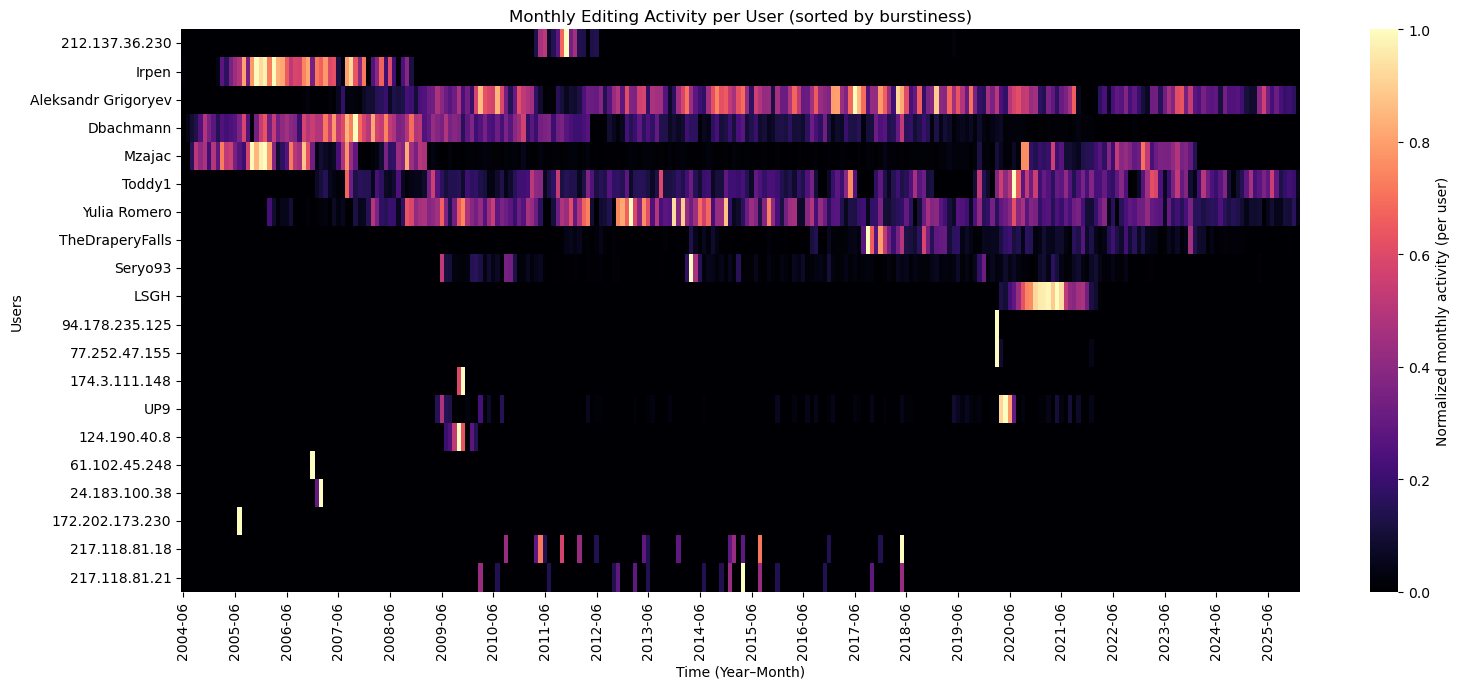

In [41]:
burst_heatmap(df_contrib, normalization="max", show_user_labels=True)

## Namespace

In [ ]:
WIKIPEDIA_NAMESPACES = {
    -2: "Media",
    -1: "Special",
     0: "Article",
     1: "Talk",
     2: "User",
     3: "User Talk",
     4: "Wikipedia",
     5: "Wikipedia Talk",
     6: "File",
     7: "File Talk",
     8: "MediaWiki",
     9: "MediaWiki Talk",
    10: "Template",
    11: "Template Talk",
    12: "Help",
    13: "Help Talk",
    14: "Category",
    15: "Category Talk",
    100: "Portal",
    101: "Portal Talk",
    118: "Draft",
    119: "Draft Talk",
    126: "MOS",
    127: "MOS Talk",
    710: "TimedText",
    711: "TimedText Talk",
    828: "Module",
    829: "Module Talk",
    1728: "Event",
    1729: "Event Talk",
    108: "Book",
    109: "Book Talk",
    442: "Course",
    423: "Course Talk",
    444: "Institution",
    445: "Institution Talk",
    446: "Education Program",
    447: "Education Program Talk",
    2300: "Gadget",
    2301: "Gadget Talk",
    2302: "Gadget Definition",
    2303: "Gadget Definition Talk",
    2600: "Topic"
}


def add_namespace_label(df, ns_col="ns"):
    """
    Adds a column 'namespace' to the usercontribs dataframe
    that translates namespace IDs to human-readable names.

    Parameters
    ----------
    df : pd.DataFrame
        User contributions dataframe containing a column with namespace IDs.
    ns_col : str
        Column name storing the namespace ID (default: 'ns').

    Returns
    -------
    pd.DataFrame
        Copy of dataframe with new column 'namespace' (string).
    """

    df = df.copy()

    df["namespace"] = df[ns_col].map(WIKIPEDIA_NAMESPACES).fillna("Unknown namespace")

    return df

def classify_namespace_family(df):
    """
    Adds a 'namespace_family' column grouping content namespaces
    with their corresponding Talk namespaces.

    For example:
    - ns=0 and ns=1 → 'Article'
    - ns=2 and ns=3 → 'User'
    - ns=10 and ns=11 → 'Template'

    Works for all namespaces defined in the global mapping.
    """

    df = df.copy()

    df["namespace_label"] = df["ns"].map(WIKIPEDIA_NAMESPACES)
    df["namespace_family"] = df["namespace_label"].str.replace(" Talk", "")

    return df

def compute_namespace_distribution(df):
    """
    Returns a table showing how many edits a user made in each namespace.

    Output columns:
    - username
    - namespace_family
    - edit_count
    """

    df = classify_namespace_family(df)

    counts = (
        df.groupby(["username", "namespace_family"])
          .size()
          .reset_index(name="edit_count")
    )

    return counts

def compute_user_namespace_profile(df):
    """
    Computes how many edits each user made in each namespace,
    returning a pivoted table (users × namespaces).
    """

    counts = compute_namespace_distribution(df)

    pivot = counts.pivot_table(
        index="username",
        columns="namespace_family",
        values="edit_count",
        fill_value=0
    )

    return pivot

In [3]:
import requests
import time

URL = "https://en.wikipedia.org/w/api.php"
HEADERS = {
    "User-Agent": "DH_Project/1.0 (https://www.epfl.ch/labs/dhlab/; maxime.garambois@epfl.ch)"
}

def get_user_revisions(username, max_edits=None, sleep=0.5):
    params = {
        "action": "query",
        "list": "usercontribs",
        "ucuser": username,
        "ucprop": "ids|title|timestamp|comment|sizediff|flags|tags|oresscores",
        "uclimit": 500,
        "format": "json",
    }

    edits = []

    session = requests.Session()
    session.headers.update(HEADERS)

    while True:
        r = session.get(URL, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()

        contribs = data.get("query", {}).get("usercontribs", [])

        for c in contribs:
            c["username"] = username

        edits.extend(contribs)

        if max_edits and len(edits) >= max_edits:
            return edits[:max_edits]

        if "continue" not in data:
            break

        params.update(data["continue"])
        time.sleep(sleep)  # polite API usage

    return edits

all_edits = []

df_contrib2 = pd.read_csv('../../datas/interim/All Users Analysis/top_user_contribs.csv')
df_contrib2_ip = pd.read_csv('../../datas/interim/All Users Analysis/ip_user_contribs_df.csv')

a1 = df_contrib2['username'].unique()
a2 = df_contrib2_ip['username'].unique()
usernames = np.concatenate([a1, a2])

for user in tqdm(usernames):
    all_edits.extend(get_user_revisions(user))

df_contrib = pd.DataFrame(all_edits)
df_contrib.to_csv(
    "../../datas/interim/All Users Analysis/users_contribs.csv",
    index=False
)

100%|███████████████████████████████████████████| 20/20 [26:40<00:00, 80.04s/it]
